## Understanding the Evaluation Metric
### Formula:
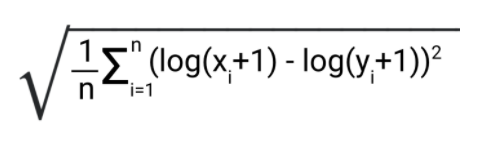

* Here $x_i$ is predicted value and $y_i$ is actual value
* $n$ is total number of predictions
* `log` is natural logarithm (important component)
* `+1` exists to avoid 0 as an input to `log`


### Difference: 
* applying logarithm to both input and target will tone-down the effects of outliers
* the consequence of that is not underscoring the scale of error but focusing on relative error

### Why not MSE?
Since there shouldn't be any distinction b/w predicting the prices of expensive houses over inexpensive ones, MSLE is desirable

### What does `0.11` MSLE mean? 
That means on an average, TA's predition of a house prices are with-in `~11.16%` of actual price. 

### Default submission
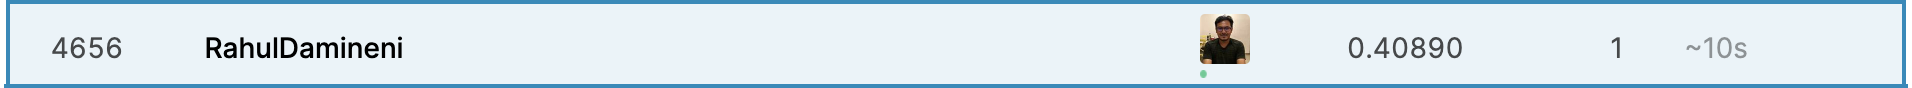

### Team Name
RahulDamineni

## Naive data processing: binarizing all fields

In [4]:
%%bash

for i in `seq 2 80`; do cat hw3-data/my_train.csv | cut -f $i -d ',' | sort | uniq | wc -l; done | \
awk '{s+=$1-1} END {print s}'

7227


In [171]:
import numpy as np
import pandas as pd
import pathlib 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge

In [142]:
train_df = pd.read_csv("hw3-data/my_train.csv")
eval_df = pd.read_csv("hw3-data/my_dev.csv")
test_df = pd.read_csv("hw3-data/test.csv")

In [143]:
train_df = train_df.drop(["Id"], axis=1)
eval_df = eval_df.drop(["Id"], axis=1)

test_id = test_df["Id"]
test_df = test_df.drop(["Id"], axis=1)

In [121]:
for col_name in train_df:
    print(f'{col_name}:\t {len(train_df[col_name].unique())}')

MSSubClass:	 15
MSZoning:	 5
LotFrontage:	 108
LotArea:	 989
Street:	 2
Alley:	 3
LotShape:	 4
LandContour:	 4
Utilities:	 2
LotConfig:	 5
LandSlope:	 3
Neighborhood:	 25
Condition1:	 9
Condition2:	 8
BldgType:	 5
HouseStyle:	 8
OverallQual:	 10
OverallCond:	 9
YearBuilt:	 110
YearRemodAdd:	 61
RoofStyle:	 6
RoofMatl:	 8
Exterior1st:	 15
Exterior2nd:	 16
MasVnrType:	 5
MasVnrArea:	 305
ExterQual:	 4
ExterCond:	 5
Foundation:	 6
BsmtQual:	 5
BsmtCond:	 5
BsmtExposure:	 5
BsmtFinType1:	 7
BsmtFinSF1:	 601
BsmtFinType2:	 7
BsmtFinSF2:	 131
BsmtUnfSF:	 730
TotalBsmtSF:	 686
Heating:	 6
HeatingQC:	 4
CentralAir:	 2
Electrical:	 6
1stFlrSF:	 721
2ndFlrSF:	 390
LowQualFinSF:	 21
GrLivArea:	 810
BsmtFullBath:	 4
BsmtHalfBath:	 3
FullBath:	 4
HalfBath:	 3
BedroomAbvGr:	 8
KitchenAbvGr:	 4
KitchenQual:	 4
TotRmsAbvGrd:	 12
Functional:	 7
Fireplaces:	 4
FireplaceQu:	 6
GarageType:	 7
GarageYrBlt:	 97
GarageFinish:	 4
GarageCars:	 5
GarageArea:	 422
GarageQual:	 6
GarageCond:	 6
PavedDrive:	 3
Woo

* My linear regressor already includes a bias term 

In [122]:
train_X = train_df.iloc[:, :-1]
train_y = train_df["SalePrice"]

eval_X = eval_df.iloc[:, :-1]
eval_y = eval_df["SalePrice"]

test_X = test_df

In [159]:
def bin_df(train_X, eval_X, test_X, method="all"):
    df = pd.concat([train_X, eval_X, test_X], axis=0)
    
    tr_lower = len(train_X)
    ev_lower = len(eval_X)
    
    if method == "all":
        bin_df = pd.get_dummies(df, columns=df.columns)
    else:
        bin_df = pd.get_dummies(df)
    
    train_Xb = bin_df[:tr_lower]
    eval_Xb = bin_df[tr_lower: tr_lower + ev_lower]
    test_Xb = bin_df[tr_lower + ev_lower:]
    
    return train_Xb, eval_Xb, test_Xb


tr_Xb, ev_Xb, te_Xb = bin_df(train_X, eval_X, test_X)

In [160]:
lr = LinearRegression()
lr.fit(tr_Xb, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [161]:
np.sqrt(mean_squared_log_error(eval_y, lr.predict(ev_Xb)))

0.16956576725615993

In [162]:
# Top 10 most negative
tr_Xb.columns[np.argpartition(lr.coef_, range(10))[:10]].tolist()

['MSZoning_C (all)',
 'FullBath_1',
 'TotRmsAbvGrd_4',
 'OverallQual_3',
 'GarageCars_1.0',
 'OverallQual_4',
 'LotFrontage_130.0',
 'LotArea_40094',
 'MasVnrArea_762.0',
 'BsmtFinSF1_2260.0']

In [163]:
# Top 10 most Positive
tr_Xb.columns[np.argpartition(-lr.coef_, range(10))[:10]].tolist()

['FullBath_3',
 'Neighborhood_StoneBr',
 'OverallQual_10',
 'Neighborhood_NoRidge',
 'RoofMatl_WdShngl',
 'OverallQual_9',
 'GarageCars_3.0',
 'LotArea_13891',
 'TotRmsAbvGrd_10',
 'LotArea_15623']

Yes, they make sense

In [148]:
# Bias dimention
lr.intercept_

230876.99037990492

Makes sense. Looks like the average price of house

In [149]:
def write_predictions(test_X, file_name):
    
    preds = lr.predict(test_X)
    out = {
        "Id": test_id,
        "SalePrice": preds
    }
    
    pd.DataFrame(out).to_csv(file_name, index=False)

write_predictions(test_X=te_Xb, file_name="hw3-data/lr_all_bin_submission.csv")

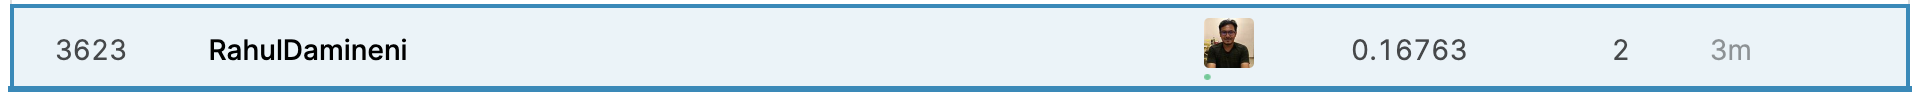

## Smarter binarization

1. Too many numerical values resulting in large and sparse vectors. This will result in large number of linear regressor parameters with too few examples to train on.

2.  LotFrontage and GarageYrBlt are still numerical: `NA` is imputed with `0`

3. 268 categorical, 36 numerical


In [177]:
tr_Xb, ev_Xb, te_Xb = bin_df(train_X.fillna(0), eval_X.fillna(0), test_X.fillna(0), method="catg")

lr = LinearRegression()
lr.fit(tr_Xb, train_y)

# Dev error
np.sqrt(mean_squared_log_error(eval_y, lr.predict(ev_Xb)))

0.1378254382288181

In [167]:
# Top 10 most negative
tr_Xb.columns[np.argpartition(lr.coef_, range(10))[:10]].tolist()

['RoofMatl_ClyTile',
 'Condition2_PosN',
 'PoolQC_Fa',
 'PoolQC_Gd',
 'GarageCond_Ex',
 'Condition2_RRAe',
 'Functional_Sev',
 'Electrical_Mix',
 'GarageQual_Po',
 'LandSlope_Sev']

In [168]:
# Top 10 most positive
tr_Xb.columns[np.argpartition(-lr.coef_, range(10))[:10]].tolist()

['PoolQC_0',
 'RoofMatl_Membran',
 'RoofMatl_WdShngl',
 'RoofMatl_Metal',
 'Condition2_PosA',
 'GarageQual_Ex',
 'RoofStyle_Shed',
 'Condition2_Artery',
 'RoofMatl_Tar&Grv',
 'Neighborhood_StoneBr']

In [169]:
# Bias dimension
lr.intercept_

-467312.2611190686

In [178]:
write_predictions(test_X=te_Xb, file_name="hw3-data/lr_catg_bin_submission.csv")

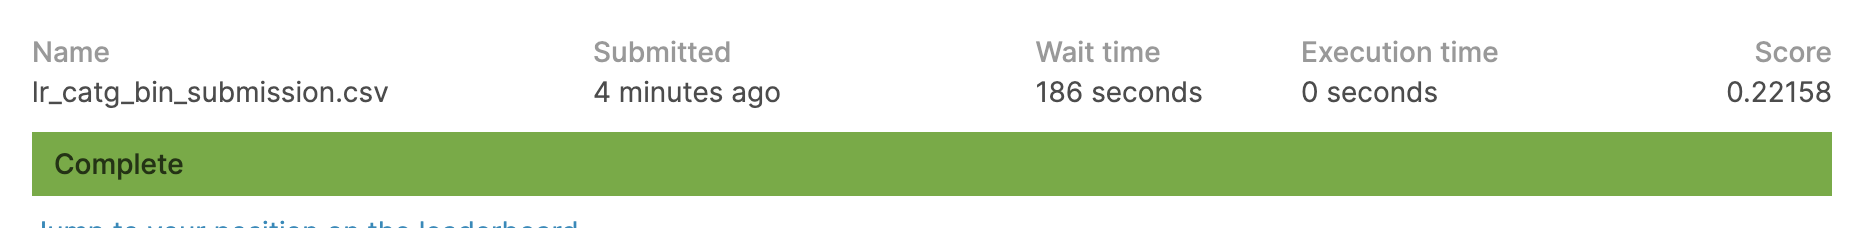

## Experimentation

In [179]:
rr = Ridge(alpha=24)
rr.fit(tr_Xb, train_y)

# Dev error
np.sqrt(mean_squared_log_error(eval_y, rr.predict(ev_Xb)))

write_predictions(test_X=te_Xb, file_name="hw3-data/rr_catg_bin_submission.csv")

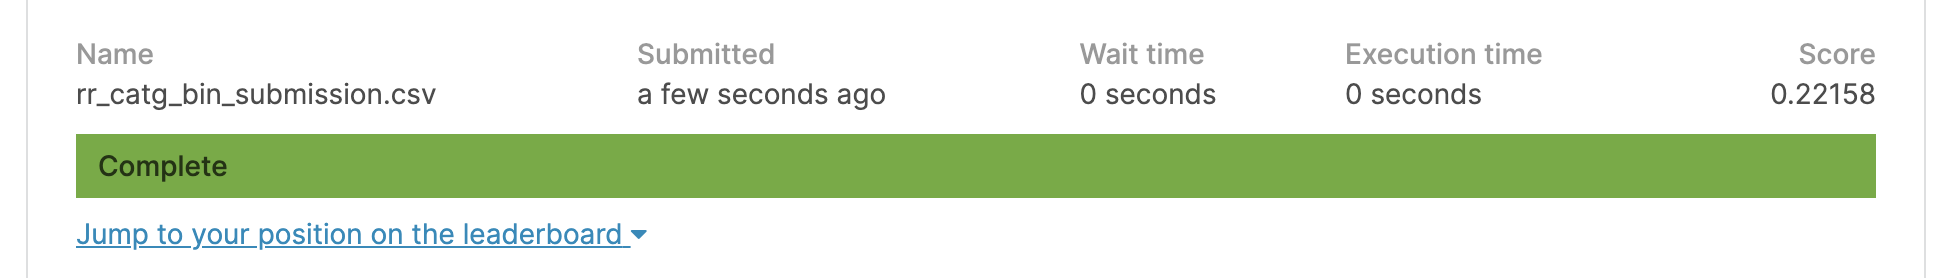

#### Best dev_error: 0.13
#### Best test_error: 0.16
#### Best rank: 3623

## Debriefing

1. 3 hours
2. Moderate
3. Mostly alone
4. 60%
